In [13]:
#get aws keys
import csv
with open('private/accessKeys.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for line in readCSV:
        access_key = line[0]
        secret_key = line[1]

In [14]:
#use pyathenajdbc to query an athena table
from pyathenajdbc import connect
import pandas as pd
import numpy as np
connection = connect(access_key=access_key, secret_key=secret_key, s3_staging_dir='s3://spark-one-off/pyathena/',
    region_name='us-west-2')

In [15]:
#read train table into dataframe...is slow, likely due to pyathenajdbc
query = 'select * from oneoff.train'
train = pd.read_sql(query, connection)
print train.dtypes
train.head(5)

id           int64
ran_num    float64
class       object
xscore     float64
oscore     float64
bscore     float64
x0         float64
y0         float64
x          float64
y          float64
dtype: object


,id,ran_num,class,xscore,oscore,bscore,x0,y0,x,y
0,0,0.940013,B,0.0,0.0,1.0,3.427153,4.636013,3.029617,5.159860
1,1,0.702143,O,0.0,1.0,0.0,1.922275,-0.479429,2.526091,0.101899
2,2,0.360001,B,0.0,0.0,1.0,5.809080,-0.600314,5.616795,0.300308
3,3,0.866404,X,1.0,0.0,0.0,0.318840,0.819390,1.027706,0.905381
4,4,0.389781,B,0.0,0.0,1.0,2.241313,-4.443623,2.684458,-4.291421


In [16]:
#get indices of X, O and B classes
print 'number of records in train = ', len(train)
idx_x = train['class'] == 'X'
idx_o = train['class'] == 'O'
idx_b = train['class'] == 'B'
print 'X fraction = ', idx_x.sum()*1.0/len(idx_x)
print 'O fraction = ', idx_o.sum()*1.0/len(idx_o)
print 'B fraction = ', idx_b.sum()*1.0/len(idx_b)
print 'B/O ratio = ', idx_b.sum()*1.0/idx_o.sum()

number of records in train =  12000
X fraction =  0.13425
O fraction =  0.126083333333
B fraction =  0.739666666667
B/O ratio =  5.86649041639


In [17]:
#prep plots
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.2, font='DejaVu Sans')

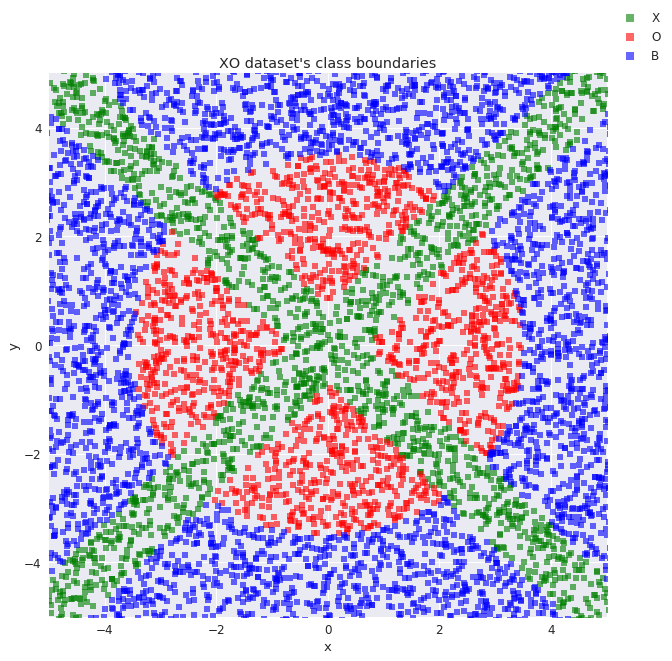

In [18]:
#scatterplot of jitterless (x0,y0) data, to show actual decision boundaries
f, ax = plt.subplots(figsize=(10, 10))
df = train
clr = 'green'
idx = idx_x
xp = df['x0'][idx]
yp = df['y0'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='X')
clr = 'red'
idx = idx_o
xp = df['x0'][idx]
yp = df['y0'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='O')
clr = 'blue'
idx = idx_b
xp = df['x0'][idx]
yp = df['y0'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='B')
p.set_title("XO dataset's class boundaries")
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)

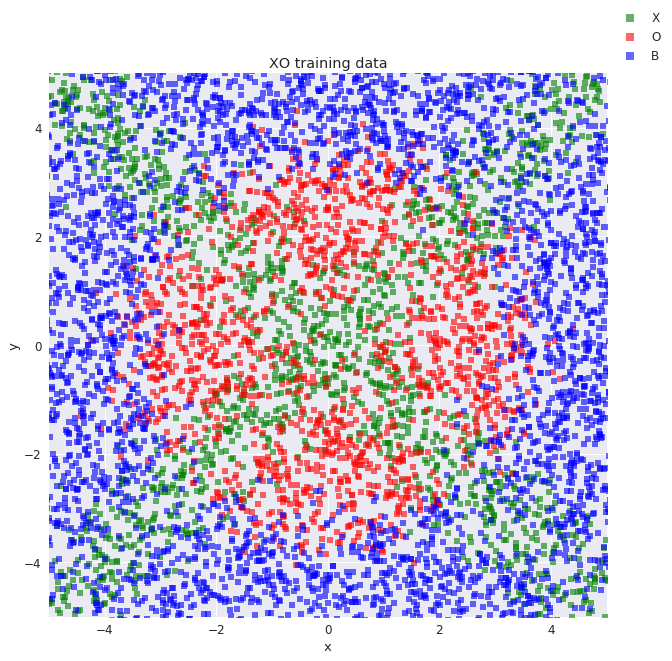

In [19]:
#scatterplot of training (x,y) data
f, ax = plt.subplots(figsize=(10, 10))
df = train
clr = 'green'
idx = idx_x
xp = df['x'][idx]
yp = df['y'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='X')
clr = 'red'
idx = idx_o
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='O')
clr = 'blue'
idx = idx_b
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='B')
p.set_title('XO training data')
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)

In [20]:
#get the number of different hidden layers
pd.read_sql('select distinct(N_hidden) as N from oneoff.grid order by N', connection)

,N
0,7
1,30
2,150
3,1000


x             float64
y             float64
class_pred     object
n_hidden        int64
dtype: object
number of records in grid =  10201
     x    y class_pred  n_hidden
0 -5.0 -5.0          X         7
1 -4.9 -5.0          X         7
2 -4.8 -5.0          X         7
3 -4.7 -5.0          X         7
4 -4.6 -5.0          X         7


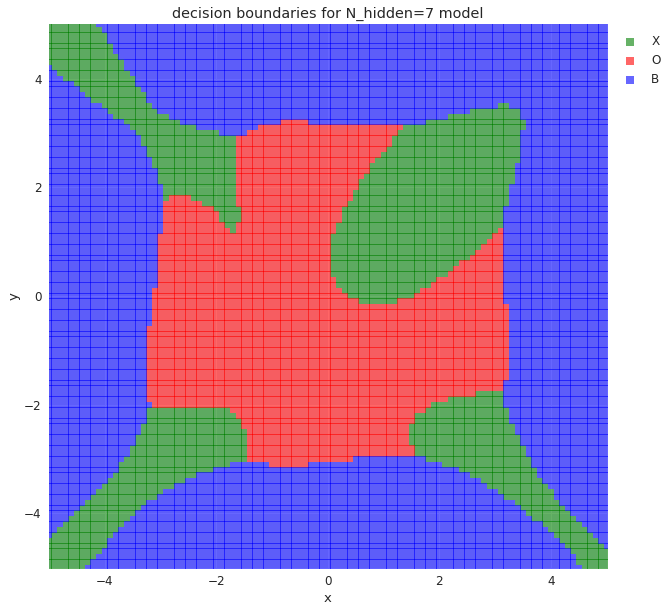

In [21]:
#decision surface for MLP model having N_hidden=7
query = 'select * from oneoff.grid where (N_hidden=7)'
grid = pd.read_sql(query, connection)
print grid.dtypes
print 'number of records in grid = ', len(grid)
print grid.head(5)
f, ax = plt.subplots(figsize=(10, 10))
df = grid
clr = 'green'
idx = df['class_pred'] == 'X'
xp = df['x'][idx]
yp = df['y'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='X')
clr = 'red'
idx = df['class_pred'] == 'O'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='O')
clr = 'blue'
idx = df['class_pred'] == 'B'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='B')
p.set_title("decision boundaries for N_hidden=7 model")
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)
grid7 = grid

x             float64
y             float64
class_pred     object
n_hidden        int64
dtype: object
number of records in grid =  10201
     x    y class_pred  n_hidden
0 -5.0 -5.0          X        30
1 -4.9 -5.0          X        30
2 -4.8 -5.0          X        30
3 -4.7 -5.0          X        30
4 -4.6 -5.0          X        30


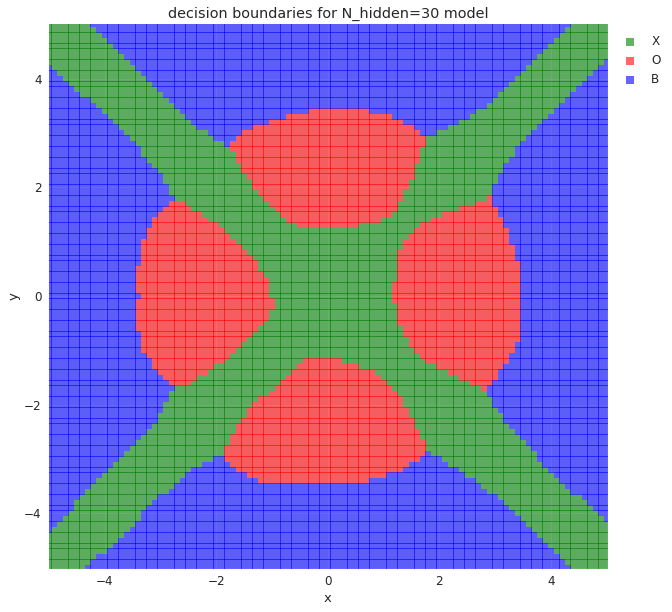

In [22]:
#decision surface for MLP model having N_hidden=20
query = 'select * from oneoff.grid where (N_hidden=32)'
grid = pd.read_sql(query, connection)
print grid.dtypes
print 'number of records in grid = ', len(grid)
print grid.head(5)
f, ax = plt.subplots(figsize=(10, 10))
df = grid
clr = 'green'
idx = df['class_pred'] == 'X'
xp = df['x'][idx]
yp = df['y'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='X')
clr = 'red'
idx = df['class_pred'] == 'O'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='O')
clr = 'blue'
idx = df['class_pred'] == 'B'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='B')
p.set_title("decision boundaries for N_hidden=20 model")
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)
grid20 = grid

x             float64
y             float64
class_pred     object
n_hidden        int64
dtype: object
number of records in grid =  10201
     x    y class_pred  n_hidden
0 -2.2 -3.0          X       150
1 -2.1 -3.0          X       150
2 -2.0 -3.0          X       150
3 -1.9 -3.0          B       150
4 -1.8 -3.0          B       150


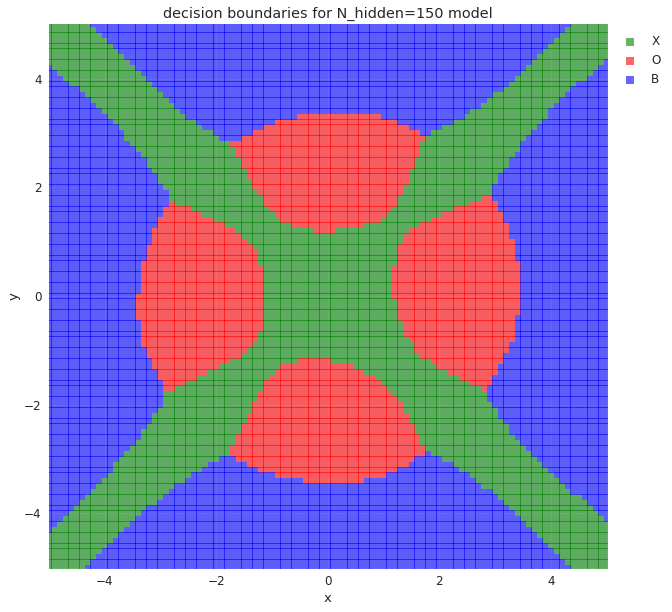

In [23]:
#decision surface for MLP model having N_hidden=60
query = 'select * from oneoff.grid where (N_hidden=60)'
grid = pd.read_sql(query, connection)
print grid.dtypes
print 'number of records in grid = ', len(grid)
print grid.head(5)
f, ax = plt.subplots(figsize=(10, 10))
df = grid
clr = 'green'
idx = df['class_pred'] == 'X'
xp = df['x'][idx]
yp = df['y'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='X')
clr = 'red'
idx = df['class_pred'] == 'O'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='O')
clr = 'blue'
idx = df['class_pred'] == 'B'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='B')
p.set_title("decision boundaries for N_hidden=60 model")
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)
grid60 = grid

x             float64
y             float64
class_pred     object
n_hidden        int64
dtype: object
number of records in grid =  10201
     x    y class_pred  n_hidden
0  2.0  0.0          O      1000
1  2.1  0.0          O      1000
2  2.2  0.0          O      1000
3  2.3  0.0          O      1000
4  2.4  0.0          O      1000


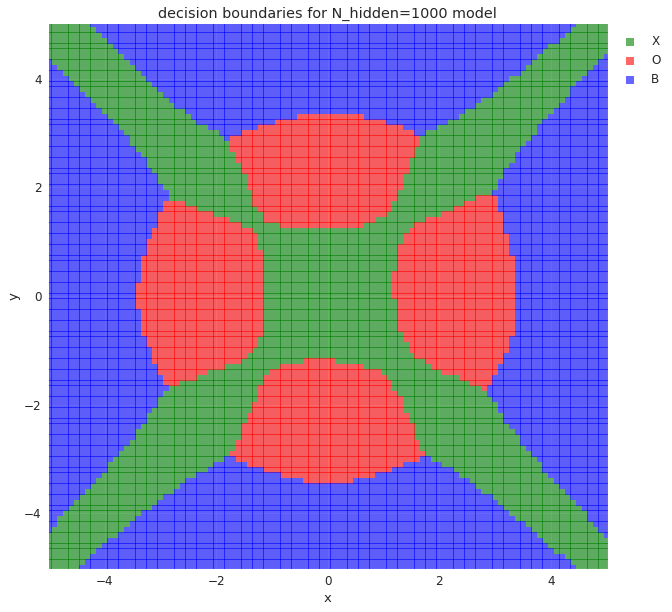

In [24]:
#decision surface for MLP model having N_hidden=200
query = 'select * from oneoff.grid where (N_hidden=200)'
grid = pd.read_sql(query, connection)
print grid.dtypes
print 'number of records in grid = ', len(grid)
print grid.head(5)
f, ax = plt.subplots(figsize=(10, 10))
df = grid
clr = 'green'
idx = df['class_pred'] == 'X'
xp = df['x'][idx]
yp = df['y'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='X')
clr = 'red'
idx = df['class_pred'] == 'O'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='O')
clr = 'blue'
idx = df['class_pred'] == 'B'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='B')
p.set_title("decision boundaries for N_hidden=200 model")
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)
grid200 = grid

In [ ]:
#decision surface for MLP model having N_hidden=1000
query = 'select * from oneoff.grid where (N_hidden=1000)'
grid = pd.read_sql(query, connection)
print grid.dtypes
print 'number of records in grid = ', len(grid)
print grid.head(5)
f, ax = plt.subplots(figsize=(10, 10))
df = grid
clr = 'green'
idx = df['class_pred'] == 'X'
xp = df['x'][idx]
yp = df['y'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='X')
clr = 'red'
idx = df['class_pred'] == 'O'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='O')
clr = 'blue'
idx = df['class_pred'] == 'B'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='B')
p.set_title("decision boundaries for N_hidden=1000 model")
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)
grid1000 = grid